# Notebook to analyze spike count within burst

## Imports

In [1]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# from matplotlib import rcParams
from mosquito.process_abf import load_processed_data
from mosquito.analyze_bursts import detect_burst_peaks, realign_spikes


## Params

In [2]:
# which example fly to look at 
data_folder = '23_20240517'  #  '22_20240516' # '19_20240510'  # '24_20240520'  # '22_20240516'  # '28_20240529'
axo_num = 6  #  9  # 4  #  1  # 7  #  6  # 2


In [3]:
# which set of flies to look at
data_files = [19.1, 19.2, 19.4, 19.5, 19.6,
              22.0, 22.1, 22.2, 22.4, 22.5, 22.6, 22., 22.8, 22.9, 22.12,
              23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 
              24.7, 24.8, 
              26.1, 26.2, 26.3, 
              28.0, 28.1, 28.2, 28.5, 28.6, 28.8, 28.9, 
              29.7, 29.8]


In [4]:
# plot params
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Helper functions


In [5]:
def get_burst_peaks_all(data):
    """
    Wrapper function for detect_burst_peaks that should let me get peak numbers from a full 
    trial data file
    
    """
    spike_idx = data['spike_idx']
    emg = data['emg']
    t = data['time']
    
    n_peaks_list = list()
    
    for idx in spike_idx:
        peaks, peaks_df = detect_burst_peaks(emg, t, idx, viz_flag=False)
        n_peaks_list.append(peaks.size)

    return n_peaks_list
    

In [45]:
def sliding_avg(x, w=3):
    """
    Implementation from stack overflow

    https://stackoverflow.com/questions/13728392/moving-average-or-running-mean/60673218#60673218
    
    """
    # x_ = np.insert(x, 0, 0)
    # sliding_average = x_[:w].sum() / w + np.cumsum(x_[w:] - x_[:-w]) / w
    # return sliding_average
    x_ser = pd.Series(data=x)
    sliding_average = x_ser.rolling(w).mean()
    return sliding_average.values
    
    

In [50]:
def moving_slope(vec, supportlength=3, modelorder=1, dt=1):
    """
    Estimate local slope for a sequence of points, using a sliding window

    movingslope uses filter to determine the slope of a curve stored
    as an equally (unit) spaced sequence of points. A patch is applied
    at each end where filter will have problems. A non-unit spacing
    can be supplied.
    
    Note that with a 3 point window and equally spaced data sequence,
    this code should be similar to gradient. However, with wider
    windows this tool will be more robust to noisy data sequences.

    From https://www.mathworks.com/matlabcentral/fileexchange/16997-movingslope

    Arguments:
        vec - row of column vector, to be differentiated. vec must be of
            length at least 2.

        supportlength - (OPTIONAL) scalar integer - defines the number of
            points used for the moving window. supportlength may be no
            more than the length of vec.
        
            supportlength must be at least 2, but no more than length(vec)
        
            If supportlength is an odd number, then the sliding window
            will be central. If it is an even number, then the window
            will be slid backwards by one element. Thus a 2 point window
            will result in a backwards differences used, except at the
            very first point, where a forward difference will be used.
        
            DEFAULT: supportlength = 3
        
        modelorder - (OPTIONAL) - scalar - Defines the order of the windowed
            model used to estimate the slope. When model order is 1, the
            model is a linear one. If modelorder is less than supportlength-1.
            then the sliding window will be a regression one. If modelorder
            is equal to supportlength-1, then the window will result in a
            sliding Lagrange interpolant.
        
            modelorder must be at least 1, but not exceeding
            min(10,supportlength-1)
        
            DEFAULT: modelorder = 1
        
        dt - (OPTIONAL) - scalar - spacing for sequences which do not have
            a unit spacing.
        
            DEFAULT: dt = 1

    Returns:
        Dvec = vector of derivative estimates, Dvec will be of the same size
            and shape as is vec.
    """
    # helper function to get filter coefficients
    def getcoef(t, supportlength, modelorder):
        a = (np.tile(t, (modelorder+1, 1)).T)**np.tile(np.arange(modelorder+1), (supportlength,1))
        pinva = np.linalg.pinv(a)
        coef = pinva[1,:]
        return coef

    # length of input vector
    n = vec.size
    
    # build filter coefficients to estimate slope
    if (supportlength % 2) == 1:
        parity = 1  # odd parity
    else:
        parity = 0  # even parity
        
    s = (supportlength - parity)/2
    t = np.arange(-s + 1 - parity, s + 1)
    coef = getcoef(t, supportlength, modelorder)

    # Apply the filter to the entire vector
    f = signal.lfilter(-coef, 1, vec)
    Dvec = np.zeros(vec.shape)
    idx = slice(int(s + 1), int(s + n - supportlength))
    Dvec[idx] = f[supportlength:-1]

    # Patch each end
    for ith in range(int(s)):
        # patch the first few points
        t = np.arange(supportlength) - ith
        coef = getcoef(t, supportlength, modelorder)
        Dvec[ith] = coef*vec[:supportlength]
        
    return Dvec

In [26]:
def getcoef(t, supportlength, modelorder):
        a = (np.tile(t, (modelorder+1, 1)).T)**np.tile(np.arange(modelorder+1), (supportlength,1))
        pinva = np.linalg.pinv(a)
        coef = pinva[1,:]
        return coef

In [27]:
# # testing for function
# vec = spike_mean
# n = vec.size
# supportlength = 3
# modelorder=1

# parity = supportlength % 2
# s = (supportlength - parity)/2
# t = np.arange(-s + 1 - parity, s+1)

# coef = getcoef(t, supportlength, modelorder)

# f = signal.lfilter(-coef, 1, vec)
# Dvec = np.zeros(vec.shape)
# idx = slice(int(s + 1), int(s + n - supportlength))
# Dvec[idx] = f[supportlength:-1]


In [28]:
# vec = spike_mean
# Dvec = moving_slope(vec)

In [29]:
# sig = np.gradient(spike_mean)
# sig_noise = Dvec

# corr = signal.correlate(sig_noise, sig)
# lags = signal.correlation_lags(len(sig), len(sig_noise))
# corr /= np.max(corr)


# fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
# ax_orig.plot(sig)
# ax_orig.set_title('Original signal')
# ax_orig.set_xlabel('Sample Number')
# ax_noise.plot(sig_noise)
# ax_noise.set_title('Signal with noise')
# ax_noise.set_xlabel('Sample Number')
# ax_corr.plot(lags, corr)
# ax_corr.set_title('Cross-correlated signal')
# ax_corr.set_xlabel('Lag')
# ax_orig.margins(0, 0.1)
# ax_noise.margins(0, 0.1)
# ax_corr.margins(0, 0.1)
# fig.tight_layout()
# plt.show()

# max_corr_idx = np.argmax(corr)
# print(lags[max_corr_idx])

## Load data

In [30]:
# load example data set
data = load_processed_data(data_folder, axo_num)


In [31]:
# Get burst info
spike_idx = data['spike_idx']
spikes = data['spikes']
emg = data['emg']
t = data['time']
window = round(data['params']['emg_window']/2)
fs = data['sampling_freq'] 

n_peaks_list = list()

for ith, idx in enumerate(spike_idx):
    # print(ith)
    peaks, peaks_df = detect_burst_peaks(emg, t, idx, min_prom_factor=0.025, viz_flag=False)
    if peaks is not None:
        n_peaks_list.append(peaks.size)

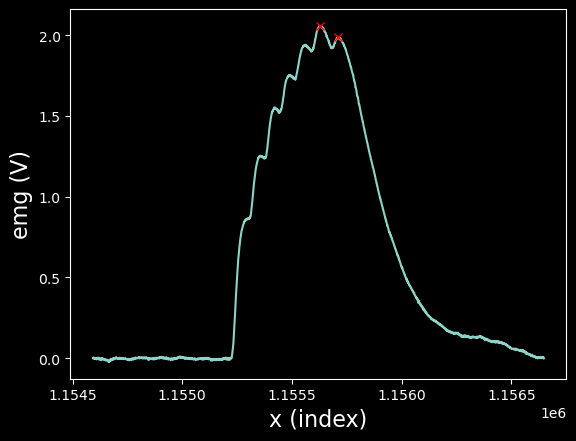

In [32]:
peaks, peaks_df = detect_burst_peaks(emg, t, spike_idx[76], min_prom_factor=0.025, viz_flag=True)

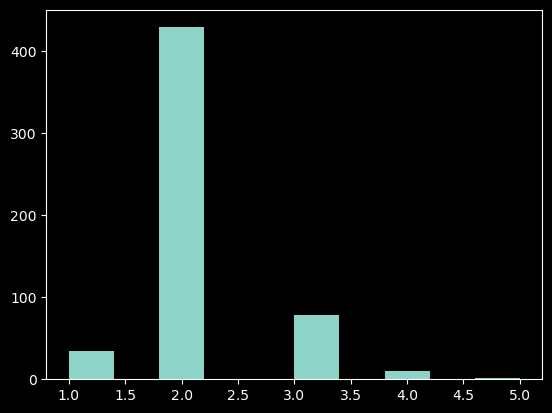

In [33]:
fig, ax = plt.subplots()
ax.hist(n_peaks_list) ; 

In [34]:
np.median(n_peaks_list)

2.0

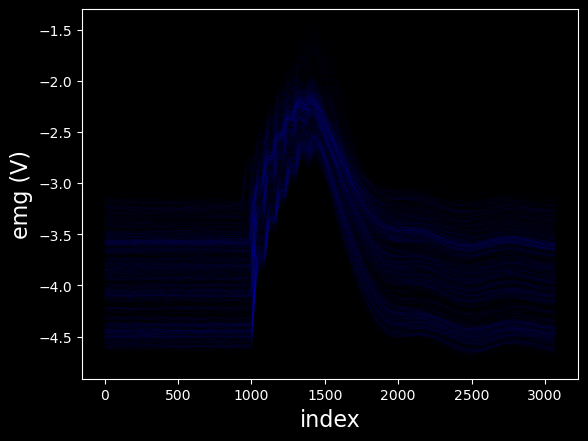

In [35]:
# try to just get average
spikes_realigned, _ = realign_spikes(spikes, spike_idx, emg, window,thresh_factor=0.3, viz_flag=True)

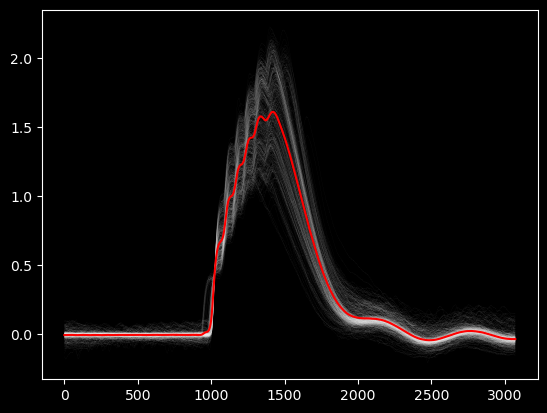

In [36]:
# zero the initial portion of spike waveform
spikes_array = np.vstack(spikes_realigned)
spikes_array -= np.reshape(np.mean(spikes_array[:, :window], axis=1), (-1, 1))
# spikes_array -= np.reshape(spikes_array[:,0], (-1, 1))

fig, ax = plt.subplots()

for spike in spikes_array:
    ax.plot(spike, lw=0.1, alpha=0.1, color='w')

ax.plot(np.mean(spikes_array, axis=0), 'r-')

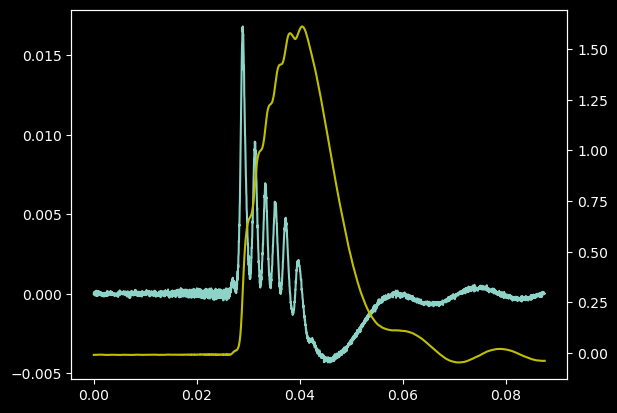

In [37]:
# look at derivative of spike waveform
spike_mean = np.mean(spikes_array, axis=0)
spike_t = (1/fs)*np.arange(spike_mean.size)

fig, ax = plt.subplots()

ax.plot(spike_t, np.gradient(spike_mean))
ax1 = ax.twinx()
ax1.plot(spike_t, spike_mean, color='y')

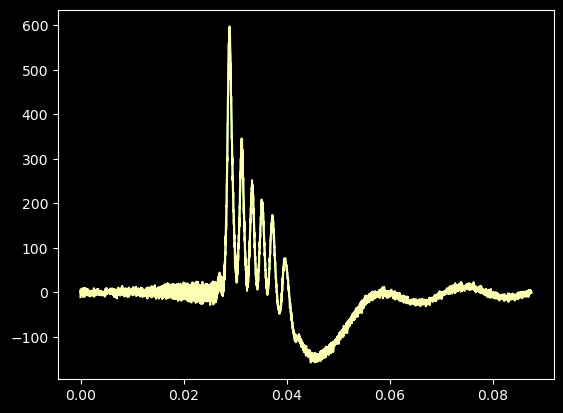

In [38]:
# try spline fit to get smoother derivative
from scipy.interpolate import CubicSpline

cs = CubicSpline(spike_t, spike_mean)

# plt.plot(spike_t, spike_mean)
# plt.plot(spike_t, cs(spike_t))
plt.plot(spike_t, fs*np.gradient(spike_mean))
plt.plot(spike_t, cs(spike_t, 1))

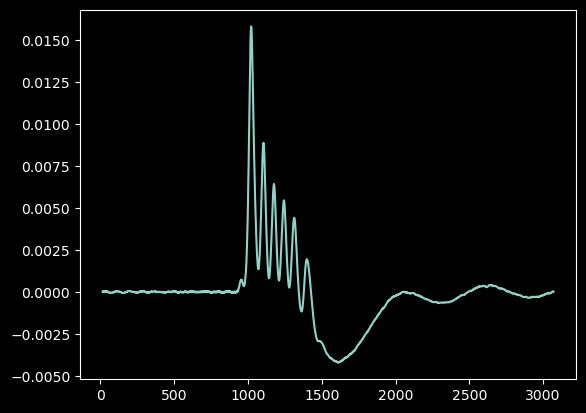

In [49]:
# try smoothed signal
spike_mean_smooth = sliding_avg(spike_mean, w=15)

# plt.plot(np.gradient(spike_mean))
plt.plot(np.gradient(spike_mean_smooth))